<a href="https://colab.research.google.com/github/ykitaguchi77/Kaggle/blob/main/Bunkruptcy-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Download Kaggle dataset**

## Google Driveのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


## データセットの準備
Kaggleと同じコードで動くよう、フォルダの関係を調整

In [1]:
import os
import shutil

# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle



os.makedirs("./input/bankruptcy-risk-prediction", exist_ok=True)
os.makedirs("./output", exist_ok=True)

# zipファイルのダウンロード
!kaggle competitions download -c bankruptcy-risk-prediction -p /content
# 解凍
!unzip ./bankruptcy-risk-prediction.zip -d ./input/bankruptcy-risk-prediction

#Zipフォルダを削除
!rm ./bankruptcy-risk-prediction.zip

#作業フォルダを作成

os.makedirs("./Kaggle", exist_ok=True)
os.chdir("./Kaggle")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/22.3k [00:00<?, ?B/s]
100% 22.3k/22.3k [00:00<00:00, 13.7MB/s]
Archive:  ./bankruptcy-risk-prediction.zip
replace ./input/bankruptcy-risk-prediction/submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')



#**Load data**

In [3]:
# load train.csv
train_df = pd.read_csv('../input/bankruptcy-risk-prediction/train.csv')

# load test.csv
test_df = pd.read_csv('../input/bankruptcy-risk-prediction/test.csv')

# load submission_example.csv
submission = pd.read_csv('../input/bankruptcy-risk-prediction/submission_example.csv')


print(f'train_df.shape = {train_df.shape}')
print(f'test_df.shape = {test_df.shape}')
print(f'submission.shape = {submission.shape}')

pd.set_option('display.max_rows', 3)
pd.set_option('display.max_columns', 1000)

train_df

train_df.shape = (800, 22)
test_df.shape = (200, 21)
submission.shape = (200, 2)


,id,sum,term,payment,guarantees,reason,credits,other_credits,credit_report,marital_status,age,employment,qualification,immigrant,residence_since,accommodation,estate,savings,dependents,phone,status,bankruptcy
0,0,1169,6,4,none,television or radio,2,none,critical account or other credits existing(not...,male single,67,7+ y.,skilled employee,yes,4,own,real estate,unknown or no savings account,1,yes,less-than 0 cu,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,799,1549,9,4,none,new car,1,none,existing credits paid back duly till now,male single,35,less-than 1 y.,unemployed or unskilled non-resident,yes,2,own,real estate,unknown or no savings account,1,none,0 to 200 cu,0


In [4]:
# #Profiling用。Runtimeの再起動を要求されるので先にインポートしておく
# !pip install pandas-profiling
# !pip install -U pandas_profiling
# !pip uninstall markupsafe
# !pip install markupsafe==2.0.1 #エラー対応

# import pandas as pd
# import pandas_profiling as pdp

# pdp.ProfileReport(train_df)


In [ ]:
# check data type(train_data)
print(train_df.dtypes)

# check missing values (train_data)
print(train_df.isnull().sum())

# check missing values (test_data)
print(test_df.isnull().sum())

In [ ]:
# check train_data describe
train_df.describe().T

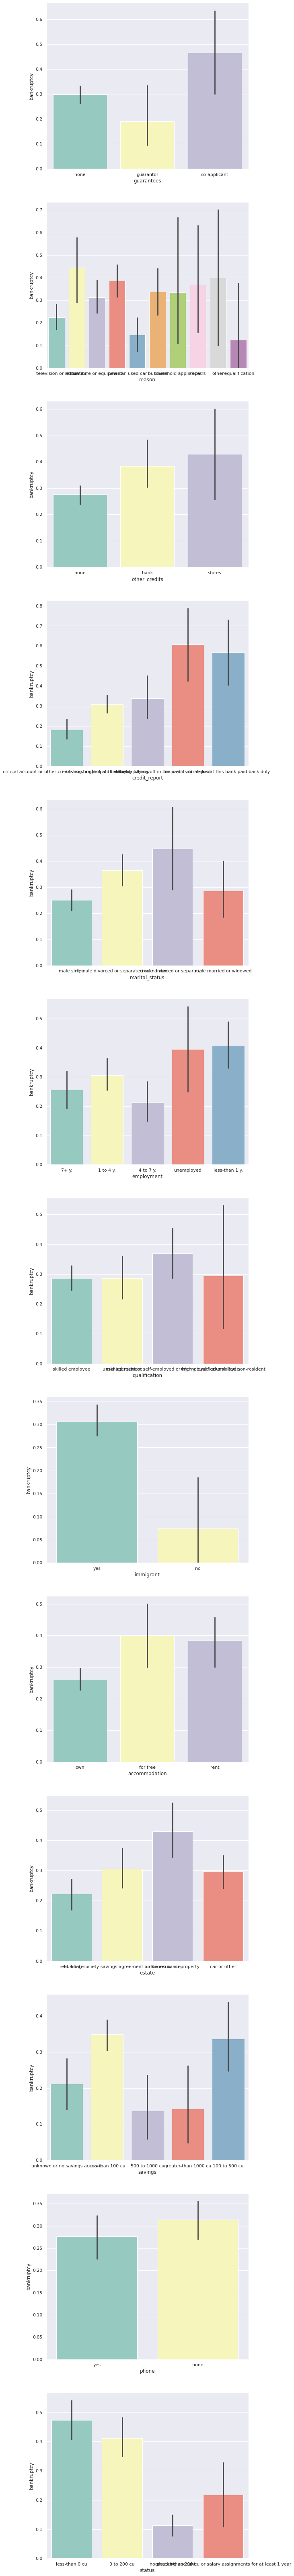

['co-applicant', 'guarantor', 'none']
['business', 'education', 'furniture or equipment', 'household appliances', 'new car', 'other', 'repairs', 'requalification', 'television or radio', 'used car']
['bank', 'none', 'stores']
['all credits at this bank paid back duly', 'critical account or other credits existing(not at this bank)', 'delay in paying off in the past', 'existing credits paid back duly till now', 'no credits or all paid']
['female divorced or separated or married', 'male divorced or separated', 'male married or widowed', 'male single']
['1 to 4 y.', '4 to 7 y.', '7+ y.', 'less-than 1 y.', 'unemployed']
['management or self-employed or highly qualified employee', 'skilled employee', 'unemployed or unskilled non-resident', 'unskilled resident']
['no', 'yes']
['for free', 'own', 'rent']
['building society savings agreement or life insurance', 'car or other', 'real estate', 'unknown or no property']
['100 to 500 cu', '500 to 1000 cu', 'greater-than 1000 cu', 'less-than 100 cu'

In [4]:
#Object項目の分布図を縦に並べて表示
import seaborn as sns
import matplotlib.pyplot as plt

categories_obj = train_df.columns[train_df.dtypes=='object'].values.tolist()
#categories

sns.set()

fig, axes = plt.subplots(len(categories_obj),1,figsize=(9,9*len(categories_obj)))   

for i in range(len(categories_obj)):
    sns.barplot(x=categories_obj[i], y="bankruptcy", data=train_df, palette="Set3", ax=axes[i])

plt.show()


for j in range(len(categories_obj)):
    print(train_df.groupby(categories_obj[j]).count().index.to_list())


In [97]:
a = train_df.groupby(categories_obj[0]).mean()["bankruptcy"] #show rate of bankruptcy in each nominal indices

print(a)

indices = train_df.groupby(categories_obj[0]).count().index.to_list()

df = train_df[categories_obj[0]]

for i in range(len(a.index)):
    print(a.index[i], a[i])
    df = df.replace(a.index[i], a[i])
print(df)




df = train_df[categories_obj[0]]
df.replace(a.index[2],a[2])


guarantees
co-applicant    0.466667
guarantor       0.190476
none            0.298077
Name: bankruptcy, dtype: float64
co-applicant 0.4666666666666667
guarantor 0.19047619047619047
none 0.2980769230769231
0      0.298077
         ...   
799    0.298077
Name: guarantees, Length: 800, dtype: float64


0      0.298077
         ...   
799    0.298077
Name: guarantees, Length: 800, dtype: object

In [93]:
indices[2]

'none'

In [12]:
train_df.groupby('estate').mean()

,id,sum,term,payment,credits,age,residence_since,dependents,bankruptcy
estate,,,,,,,,,
building society savings agreement or life insurance,417.768362,2951.079096,18.971751,2.920904,1.389831,34.310734,2.807910,1.135593,0.305085
...,...,...,...,...,...,...,...,...,...
unknown or no property,405.351562,4924.031250,26.546875,3.039062,1.390625,41.781250,3.304688,1.210938,0.429688


In [50]:
indices = train_df.groupby(categories_obj[0]).count().index.to_list()
values = train_df[categories_obj[0]]
labels = train_df["bankruptcy"]

lst = []
for i in len(range(values)):
    if labels[i] == 1:
        lst.app

TypeError: ignored

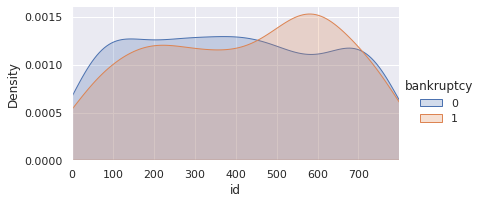

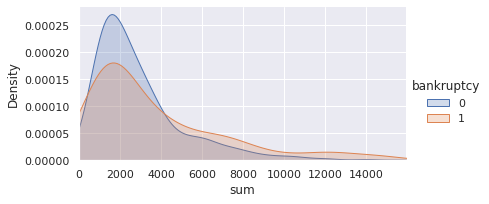

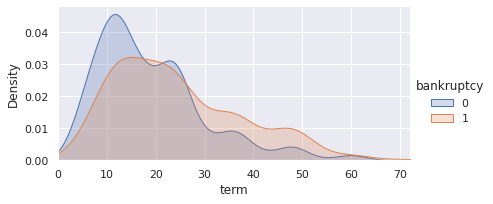

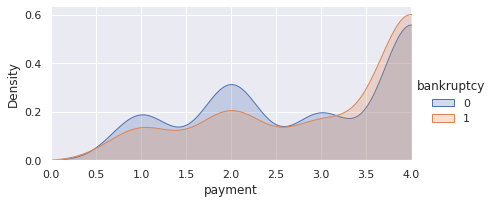

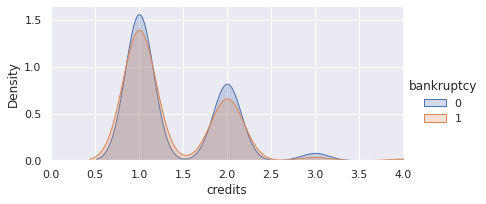

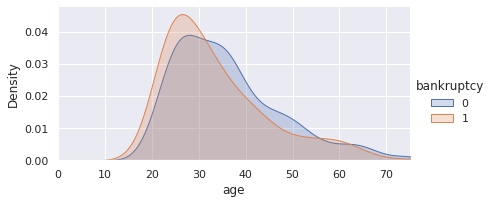

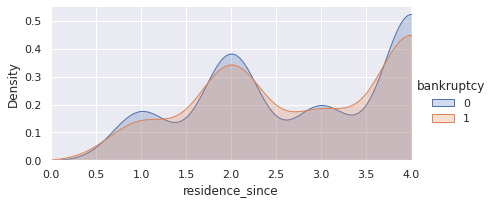

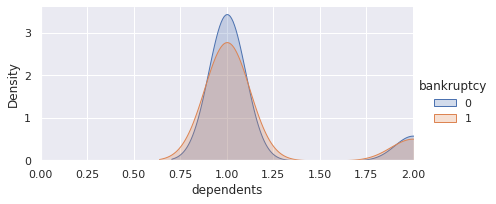

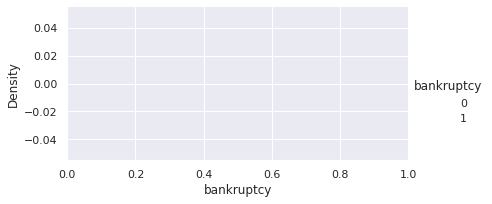

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [10]:
#Object以外の項目の分布図を縦に並べて表示
import seaborn as sns
import matplotlib.pyplot as plt

categories_float = train_df.columns[train_df.dtypes=='int64']

sns.set()
#fig, axes = plt.subplots(len(categories),1,figsize=(9,9*len(categories)))   

for i in range(len(categories_float)):
    fare = sns.FacetGrid(train_df, hue="bankruptcy",aspect=2)
    fare.map(sns.kdeplot,categories_float[i],shade= True)
    fare.set(xlim=(0, train_df[categories_float[i]].max()))
    fare.add_legend()
plt.show()


for j in range(len(categories_float)):
    print(train_df.groupby(categories_float[j]).count().index.to_list())


#**PyCaret**

In [6]:
!pip install pycaret
!pip install pandas-profiling==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 5.1 MB/s 
     |████████████████████████████████| 2.0 MB 63.9 MB/s 
     |████████████████████████████████| 25.9 MB 1.5 MB/s 
     |████████████████████████████████| 6.8 MB 37.5 MB/s 
     |████████████████████████████████| 10.4 MB 54.8 MB/s 
     |████████████████████████████████| 167 kB 54.7 MB/s 
     |████████████████████████████████| 17.0 MB 57 kB/s 
     |████████████████████████████████| 3.3 MB 55.6 MB/s 
     |████████████████████████████████| 134 kB 56.6 MB/s 
     |████████████████████████████████| 262 kB 42.5 MB/s 
     |████████████████████████████████| 1.7 MB 50.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.3 MB 53.7 MB/s 
     |███████████████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 261 kB 5.1 MB/s 
     |████████████████████████████████| 3.1 MB 52.4 MB/s 
     |████████████████████████████████| 303 kB 59.5 MB/s 
  Attempting uninstall: tangled-up-in-unicode
    Found existing installation: tangled-up-in-unicode 0.2.0
    Uninstalling tangled-up-in-unicode-0.2.0:
      Successfully uninstalled tangled-up-in-unicode-0.2.0
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: pandas-profiling
    Found existing installation: pandas-profiling 3.2.0
    Uninstalling pandas-profiling-3.2.0:
      Successfully uninstalled pandas-profiling-3.2.0


In [6]:
train_df.shape

(800, 22)

In [8]:
# init setup
from pycaret.classification import *
s = setup(data = train_df, target = 'bankruptcy', session_id=123)

,Description,Value
0,session_id,123
1,Target,bankruptcy
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(800, 22)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,17
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=['id'],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='bankruptcy', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numer...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [9]:
best_model = compare_models(sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7603,0.7723,0.5070,0.6496,0.5599,0.3996,0.4117,0.040
lr,Logistic Regression,0.7567,0.7711,0.5011,0.6348,0.5529,0.3901,0.3997,0.589
rf,Random Forest Classifier,0.7513,0.7696,0.3283,0.6980,0.4403,0.3069,0.3457,0.648
lightgbm,Light Gradient Boosting Machine,0.7263,0.7585,0.4169,0.5737,0.4772,0.2990,0.3092,0.116
nb,Naive Bayes,0.7387,0.7578,0.6599,0.5638,0.6048,0.4129,0.4182,0.026
gbc,Gradient Boosting Classifier,0.7602,0.7481,0.4581,0.6579,0.5336,0.3796,0.3949,0.278
et,Extra Trees Classifier,0.7281,0.7328,0.3577,0.6055,0.4382,0.2764,0.2983,0.603
ada,Ada Boost Classifier,0.7317,0.7324,0.4533,0.5957,0.5030,0.3248,0.3374,0.217
dt,Decision Tree Classifier,0.6583,0.5930,0.4287,0.4351,0.4281,0.1865,0.1880,0.029
knn,K Neighbors Classifier,0.6331,0.5278,0.1371,0.2794,0.1810,-0.0180,-0.0198,0.145


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
INFO:logs:compare_models() succesfully completed......................................


In [10]:
print(best_model)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


In [20]:
lda = create_model("lightgbm")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6786,0.6938,0.2353,0.4444,0.3077,0.1235,0.1341
1,0.7857,0.8084,0.4118,0.7778,0.5385,0.4157,0.4513
2,0.6964,0.7421,0.3529,0.5000,0.4138,0.2171,0.2231
3,0.6786,0.6652,0.4706,0.4706,0.4706,0.2398,0.2398
4,0.7857,0.8537,0.4706,0.7273,0.5714,0.4372,0.4556
5,0.7143,0.7647,0.4706,0.5333,0.5000,0.3011,0.3022
6,0.7679,0.7617,0.4118,0.7000,0.5185,0.3788,0.4020
7,0.6964,0.7345,0.4706,0.5000,0.4848,0.2699,0.2702
8,0.7143,0.7672,0.4375,0.5000,0.4667,0.2727,0.2739


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 7
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


In [21]:
tuned_lda = tune_model(lda)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7321,0.7104,0.2941,0.6250,0.4000,0.2553,0.2854
1,0.7500,0.8296,0.4118,0.6364,0.5000,0.3434,0.3578
2,0.7321,0.7315,0.4706,0.5714,0.5161,0.3333,0.3363
3,0.6250,0.6335,0.2353,0.3333,0.2759,0.0329,0.0338
4,0.7679,0.8401,0.4706,0.6667,0.5517,0.4013,0.4124
5,0.8214,0.7964,0.5294,0.8182,0.6429,0.5310,0.5533
6,0.7679,0.7195,0.3529,0.7500,0.4800,0.3546,0.3964
7,0.7143,0.7707,0.2353,0.5714,0.3333,0.1899,0.2202
8,0.7857,0.7062,0.3125,0.8333,0.4545,0.3538,0.4199


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 8
INFO:logs:LGBMClassifier(bagging_fraction=0.6, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=41, min_child_weight=0.001, min_split_gain=0.9,
               n_estimators=260, n_jobs=-1, num_leaves=70, objective=None,
               random_state=123, reg_alpha=2, reg_lambda=3, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


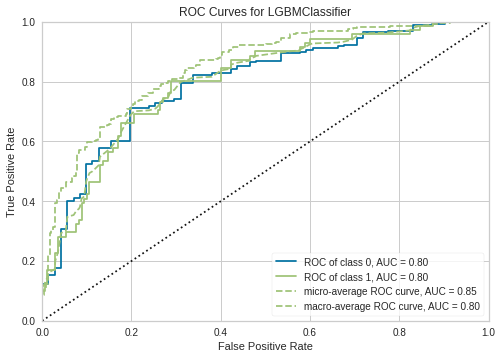

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [22]:
plot_model(tuned_lda, plot = 'auc')


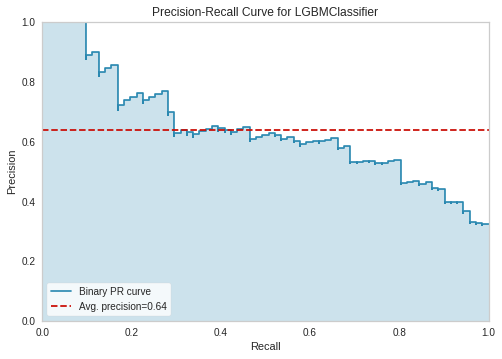

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [23]:
plot_model(tuned_lda, plot = 'pr')


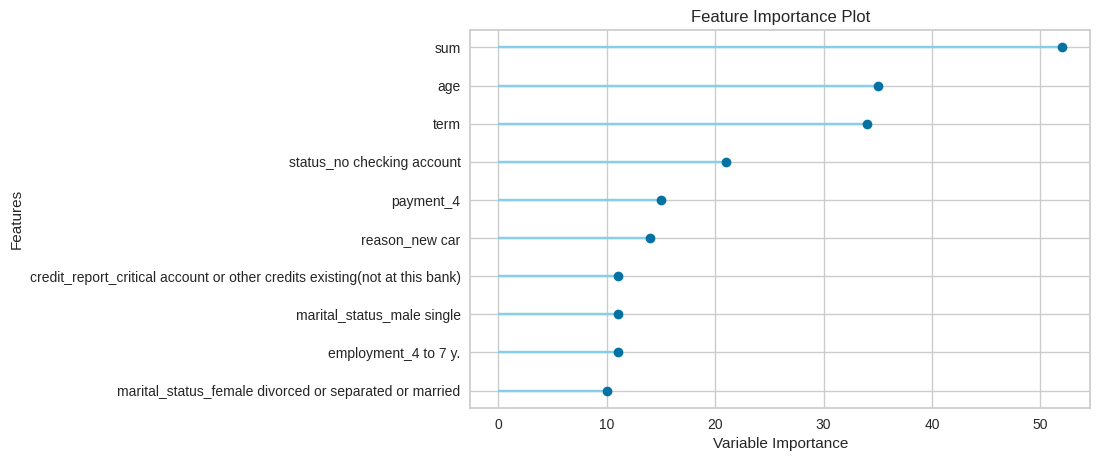

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [24]:
plot_model(tuned_lda, plot='feature')

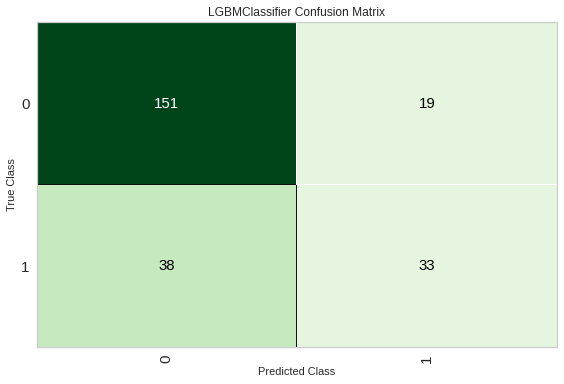

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [25]:
plot_model(tuned_lda, plot = 'confusion_matrix')


In [26]:
predict_model(tuned_lda);

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMClassifier(bagging_fraction=0.6, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=41, min_child_weight=0.001, min_split_gain=0.9,
               n_estimators=260, n_jobs=-1, num_leaves=70, objective=None,
               random_state=123, reg_alpha=2, reg_lambda=3, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7635,0.7998,0.4648,0.6346,0.5366,0.3829,0.3912


In [27]:
# finalize rf model
final_lda = finalize_model(tuned_lda)

predict_model(final_lda);


INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=LGBMClassifier(bagging_fraction=0.6, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=41, min_child_weight=0.001, min_split_gain=0.9,
               n_estimators=260, n_jobs=-1, num_leaves=70, objective=None,
               random_state=123, reg_alpha=2, reg_lambda=3, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), fit_kwargs=None, groups=None, model_only=True, display=None, experiment_custom_tags=None, return_train_score=False)
INFO:logs:Finalizing LGBMClassifier(bagging_fraction=0.6, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_sampl

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7967,0.8596,0.5211,0.7115,0.6016,0.4695,0.4797


In [29]:
unseen_predictions = predict_model(final_lda, data=test_df)


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMClassifier(bagging_fraction=0.6, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=41, min_child_weight=0.001, min_split_gain=0.9,
               n_estimators=260, n_jobs=-1, num_leaves=70, objective=None,
               random_state=123, reg_alpha=2, reg_lambda=3, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


In [30]:
unseen_predictions

,id,sum,term,payment,guarantees,reason,credits,other_credits,credit_report,marital_status,...,immigrant,residence_since,accommodation,estate,savings,dependents,phone,status,Label,Score
0,800,1597,24,4,none,education,2,none,critical account or other credits existing(not...,male single,...,yes,4,for free,unknown or no property,less-than 100 cu,2,none,no checking account,0,0.8545
1,801,1795,18,3,guarantor,television or radio,2,bank,critical account or other credits existing(not...,female divorced or separated or married,...,yes,4,rent,real estate,less-than 100 cu,1,yes,0 to 200 cu,0,0.7526
2,802,4272,20,1,none,furniture or equipment,2,none,critical account or other credits existing(not...,female divorced or separated or married,...,yes,4,own,building society savings agreement or life ins...,less-than 100 cu,1,none,less-than 0 cu,1,0.5237
3,803,976,12,4,none,television or radio,2,none,critical account or other credits existing(not...,male single,...,yes,4,own,car or other,unknown or no savings account,1,none,no checking account,0,0.9409
4,804,7472,12,1,none,new car,1,none,existing credits paid back duly till now,female divorced or separated or married,...,yes,2,rent,real estate,unknown or no savings account,1,none,0 to 200 cu,1,0.5897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,995,1736,12,3,none,furniture or equipment,1,none,existing credits paid back duly till now,female divorced or separated or married,...,yes,4,own,real estate,less-than 100 cu,1,none,no checking account,0,0.9289
196,996,3857,30,4,none,used car,1,none,existing credits paid back duly till now,male divorced or separated,...,yes,4,own,building society savings agreement or life ins...,less-than 100 cu,1,yes,less-than 0 cu,0,0.5855
197,997,804,12,4,none,television or radio,1,none,existing credits paid back duly till now,male single,...,yes,4,own,car or other,less-than 100 cu,1,none,no checking account,0,0.8828
198,998,1845,45,4,none,television or radio,1,none,existing credits paid back duly till now,male single,...,yes,4,for free,unknown or no property,less-than 100 cu,1,yes,less-than 0 cu,1,0.7256


#**Data processing**

In [20]:
from sklearn.preprocessing import OneHotEncoder

# obtain object data type as list (outcomeが数値でないラベルを抜き出す)
categories = train_df.columns[train_df.dtypes=='object'].values.tolist()

# One-hot Encoding
for cat in categories:
    
    # generate Label Encoder object
    train_df_encoder = pd.get_dummies(train_df[[cat]])
    test_df_encoder = pd.get_dummies(test_df[[cat]])

    #concat 
    train_df = pd.concat([train_df, train_df_encoder],axis=1)
    test_df = pd.concat([test_df, test_df_encoder], axis=1)
    
    #drop original (object data) categories
    train_df.drop(cat, axis=1, inplace=True)
    test_df.drop(cat, axis=1, inplace=True)

#drop duplicated columns
train_df.loc[:,~train_df.columns.duplicated()]
test_df.loc[:,~test_df.columns.duplicated()]

,id,sum,term,payment,credits,age,residence_since,dependents,guarantees_co-applicant,guarantees_guarantor,guarantees_none,reason_business,reason_education,reason_furniture or equipment,reason_household appliances,reason_new car,reason_other,reason_repairs,reason_requalification,reason_television or radio,reason_used car,other_credits_bank,other_credits_none,other_credits_stores,credit_report_all credits at this bank paid back duly,credit_report_critical account or other credits existing(not at this bank),credit_report_delay in paying off in the past,credit_report_existing credits paid back duly till now,credit_report_no credits or all paid,marital_status_female divorced or separated or married,marital_status_male divorced or separated,marital_status_male married or widowed,marital_status_male single,employment_1 to 4 y.,employment_4 to 7 y.,employment_7+ y.,employment_less-than 1 y.,employment_unemployed,qualification_management or self-employed or highly qualified employee,qualification_skilled employee,qualification_unemployed or unskilled non-resident,qualification_unskilled resident,immigrant_no,immigrant_yes,accommodation_for free,accommodation_own,accommodation_rent,estate_building society savings agreement or life insurance,estate_car or other,estate_real estate,estate_unknown or no property,savings_100 to 500 cu,savings_500 to 1000 cu,savings_greater-than 1000 cu,savings_less-than 100 cu,savings_unknown or no savings account,phone_none,phone_yes,status_0 to 200 cu,status_greater-than 200 cu or salary assignments for at least 1 year,status_less-than 0 cu,status_no checking account
0,800,1597,24,4,2,54,4,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,999,4576,45,3,1,27,4,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0


In [13]:
import scipy.stats
from sklearn import preprocessing

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 1000)

train_df = train_df.apply(scipy.stats.zscore, axis=0)
test_df = test_df.apply(scipy.stats.zscore, axis=0)

In [21]:
#Dataset

# target label
y = train_df['bankruptcy']

# predictor features
X = train_df.drop(['id', 'bankruptcy'], axis=1)
X = X.apply(scipy.stats.zscore, axis=0) #standardization

# list of categorical features
category_list = X.columns[X.dtypes=='category'].values.tolist()

# standardize testset
test_df = test_df.apply(scipy.stats.zscore, axis=0)


In [22]:
from pandas._libs.tslibs.parsing import try_parse_date_and_time
# LightGBM / hyper parameters
lgbm_params = {
    'boosting_type': 'gbdt',            # Gradient Boosting Decision Tree
    'objective': 'binary',                 # binary classification
    'metric': 'auc',                         # evaluator：AUC
    
    'learning_rate': 0.05, 
    
    'num_leaves': 32, 
    
    'n_estimators': 100000, 
    'importance_type': 'gain', 
    
    'random_state': 123, 
}

params = {
    'boosting_type': 'gbdt',            # Gradient Boosting Decision Tree
    'objective': 'binary',
    'verbose': -1,
    "metric" : "None",
    'learning_rate': 0.05, 
    'num_leaves': 32, 
    'n_estimators': 100000, 
    'importance_type': 'gain',  
    'random_state': 123, 
}

#custom_metrics
import sklearn
from sklearn.metrics import f1_score
import numpy as np
from sklearn import datasets
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
def f1(preds, data):
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    metric = 2*precision*recall/(precision+recall)
    return 'f1', metric, True

def accuracy(preds, data):
    """精度 (Accuracy) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = np.mean(y_true == y_pred)
    return 'accuracy', metric, True


def precision(preds, data):
    """適合率 (Precision) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = precision_score(y_true, y_pred)
    return 'precision', metric, True


def recall(preds, data):
    """再現率 (Recall) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = recall_score(y_true, y_pred)
    return 'recall', metric, True

def prroc(preds, data):
    """AUC を計算する関数"""
    y_true = data.get_label()
    y_pred = preds
    recall, precision, thresholds = precision_recall_curve(y_true, y_pred)
    metric = sklearn.metrics.auc(recall, precision)
    return 'prroc', metric, True

def aucroc(preds, data):
    """Precision_recall_AUC を計算する関数"""
    y_true = data.get_label()
    y_pred = preds
    metric = roc_auc_score(y_true, y_pred)
    return 'aucroc', metric, True


def metrics(preds, data): #複数onにすると、複数の指標でearly stoppingをしてしまうので注意
    """複数の評価指標を計算するための関数"""
    # リストでまとめて返せば良い
    return [
        #accuracy(preds, data),
        #precision(preds, data),
        #recall(preds, data),
        #f1(preds, data),
        aucroc(preds, data),
        #prroc(preds, data), #これはうまくいかない
    ]

#**PythonAPI_lightGBM**

In [23]:
from sklearn.metrics import log_loss


# StratifiedKFold-CV

# num of fold
folds = 5

# list of fixed models based on CV
models = []

# list of auc based on CV
auc = []

# prediction of valid data
out_of_fold = np.zeros(len(X))


# generate StratifiedKFold object and prepare train_index & valid_index
cv = list(StratifiedKFold(n_splits=folds, shuffle=True, random_state=123).split(X, y))


# CV
for n_fold in np.arange(folds):
    
    # obtain index for model fitting
    train_index = cv[n_fold][0]
    
    # obtain index for validation data
    valid_index = cv[n_fold][1]
    
    # predictor features for model fitting
    x_train_cv = X.iloc[train_index]
    
    # target label for model fitting
    y_train_cv =y.iloc[train_index]
    
    # predictor features for validation
    x_valid_cv = X.iloc[valid_index]
    
    # target label for validation
    y_valid_cv = y.iloc[valid_index]
    
    # データセットを生成する
    lgb_train = lgb.Dataset(x_train_cv, y_train_cv)
    lgb_eval = lgb.Dataset(x_valid_cv, y_valid_cv, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    evals_result = {}
    model = lgb.train(params, lgb_train, 
                  #valid_sets=lgb_eval,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # 最大イテレーション回数指定
                  early_stopping_rounds=50,
                  # メトリックを追跡する対象のデータセット
                  valid_sets=[lgb_eval, lgb_train],
                  #valid_sets=[lgb_eval],
                  # 上記の名前
                  valid_names=['eval', 'train'],
                  # メトリックの履歴を残すオブジェクト
                  evals_result=evals_result,
                  # 独自メトリックを計算する関数
                  feval=metrics,
                 )
    
    
    # predict data for model fitting
    y_pred_train = model.predict(x_train_cv)
    
    # predict validation data
    y_pred_valid = model.predict(x_valid_cv)
    
    
    # AUC
    # data for model fitting
    temp_auc_train = roc_auc_score(y_train_cv, y_pred_train)
    
    # validation data
    temp_auc_valid = roc_auc_score(y_valid_cv, y_pred_valid)

    #calculate log_loss
    logloss = log_loss(y_valid_cv, y_pred_valid)

    print(f'\nfold: {n_fold}')
    print(f'log loss: {logloss}')
    
    # AUC
    print(f'auc(train_data) = {temp_auc_train:.4f}')
    print(f'auc(valid_data) = {temp_auc_valid:.4f}\n\n')
    
    # AUC append
    auc.append([temp_auc_train, temp_auc_valid])
    
    # model append
    models.append(model)
    
    # prediction result of validation data
    out_of_fold[valid_index] = y_pred_valid

# auc into NumPy type
auc_np = np.array(auc)

# mean of auc (train data)
auc_train_mean = auc_np[:, 0].mean()
print(f'auc(train_data)_mean = {auc_train_mean:.4f}')

# mean of auc (validation data)
auc_valid_mean = auc_np[:, 1].mean()
print(f'auc(valid_data)_mean = {auc_valid_mean:.4f}')
    

Training until validation scores don't improve for 50 rounds.
[50]	train's aucroc: 0.977481	eval's aucroc: 0.732819
[100]	train's aucroc: 0.999128	eval's aucroc: 0.734137
Early stopping, best iteration is:
[77]	train's aucroc: 0.994745	eval's aucroc: 0.741103

fold: 0
log loss: 0.5486599053482634
auc(train_data) = 0.9947
auc(valid_data) = 0.7411


Training until validation scores don't improve for 50 rounds.
[50]	train's aucroc: 0.972796	eval's aucroc: 0.817336
[100]	train's aucroc: 0.998939	eval's aucroc: 0.834263
[150]	train's aucroc: 1	eval's aucroc: 0.827939
Early stopping, best iteration is:
[102]	train's aucroc: 0.999055	eval's aucroc: 0.835938

fold: 1
log loss: 0.44630788466814353
auc(train_data) = 0.9991
auc(valid_data) = 0.8359


Training until validation scores don't improve for 50 rounds.
[50]	train's aucroc: 0.977763	eval's aucroc: 0.753534
[100]	train's aucroc: 0.998682	eval's aucroc: 0.765067
[150]	train's aucroc: 1	eval's aucroc: 0.755022
Early stopping, best iteration 

#**SKlearn_lightGBM**

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.977481	valid_1's auc: 0.732819
[100]	training's auc: 0.999128	valid_1's auc: 0.734137
[150]	training's auc: 1	valid_1's auc: 0.729618
Early stopping, best iteration is:
[77]	training's auc: 0.994745	valid_1's auc: 0.741103

auc(train_data) = 0.9947
auc(valid_data) = 0.7411

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.972796	valid_1's auc: 0.817336
[100]	training's auc: 0.998939	valid_1's auc: 0.834263
[150]	training's auc: 1	valid_1's auc: 0.827939
[200]	training's auc: 1	valid_1's auc: 0.824219
Early stopping, best iteration is:
[102]	training's auc: 0.999055	valid_1's auc: 0.835938

auc(train_data) = 0.9991
auc(valid_data) = 0.8359

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.977763	valid_1's auc: 0.753534
[100]	training's auc: 0.998682	valid_1's auc: 0.765067
[150]	training's auc: 1	valid_1's auc: 0.755022
[200]	tra

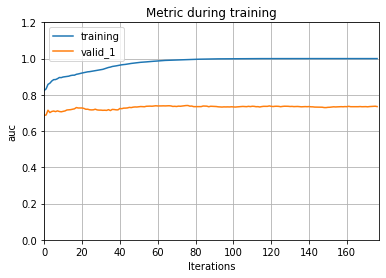

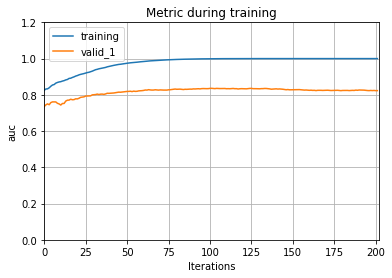

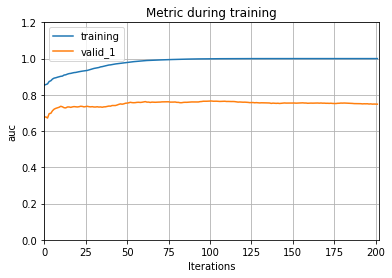

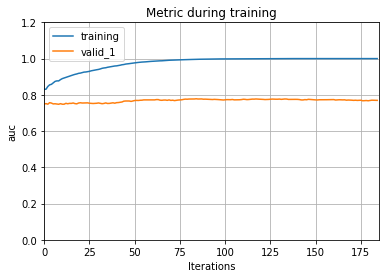

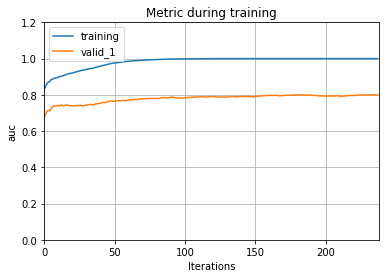

In [27]:
# StratifiedKFold-CV

# num of fold
folds = 5

# list of fixed models based on CV
models = []

# list of auc based on CV
auc = []

# prediction of valid data
out_of_fold = np.zeros(len(X))


# generate StratifiedKFold object and prepare train_index & valid_index
cv = list(StratifiedKFold(n_splits=folds, shuffle=True, random_state=123).split(X, y))


# CV
for n_fold in np.arange(folds):
    
    # obtain index for model fitting
    train_index = cv[n_fold][0]
    
    # obtain index for validation data
    valid_index = cv[n_fold][1]
    
    # predictor features for model fitting
    x_train_cv = X.iloc[train_index]
    
    # target label for model fitting
    y_train_cv = y.iloc[train_index]
    
    # predictor features for validation
    x_valid_cv = X.iloc[valid_index]
    
    # target label for validation
    y_valid_cv = y.iloc[valid_index]
    
    
    
    # generate LightGBM model object
    model = lgb.LGBMClassifier(**lgbm_params)
    
    
    # model fitting
    model.fit(
        x_train_cv, 
        y_train_cv, 
        eval_set = [(x_train_cv, y_train_cv), (x_valid_cv, y_valid_cv)], 
        early_stopping_rounds = 100, 
        categorical_feature = category_list,
        verbose = 50, 
    )
    
    
    # predict data for model fitting
    y_pred_train = model.predict_proba(x_train_cv, num_iteration=model.best_iteration_)[:, 1]
    
    # predict validation data
    y_pred_valid = model.predict_proba(x_valid_cv, num_iteration=model.best_iteration_)[:, 1]
    
    
    # AUC
    # data for model fitting
    temp_auc_train = roc_auc_score(y_train_cv, y_pred_train)
    
    # validation data
    temp_auc_valid = roc_auc_score(y_valid_cv, y_pred_valid)
    
    # AUC
    print(f'\nauc(train_data) = {temp_auc_train:.4f}')
    print(f'auc(valid_data) = {temp_auc_valid:.4f}\n')
    
    # AUC append
    auc.append([temp_auc_train, temp_auc_valid])
    
    
    # model append
    models.append(model)
    
    # prediction result of validation data
    out_of_fold[valid_index] = y_pred_valid
    
    
    # plot of model fitting curve
    lgb.plot_metric(model, ylim=(0, 1.2));

In [28]:
# auc into NumPy type
auc_np = np.array(auc)

# mean of auc (train data)
auc_train_mean = auc_np[:, 0].mean()
print(f'auc(train_data)_mean = {auc_train_mean:.4f}')

# mean of auc (validation data)
auc_valid_mean = auc_np[:, 1].mean()
print(f'auc(valid_data)_mean = {auc_valid_mean:.4f}')

auc(train_data)_mean = 0.9977
auc(valid_data)_mean = 0.7821


In [29]:
# Prediction of test data

# list of prediction based on each CV
preds_test = []


# predictor features of test data
x_test = test_df.drop(['id'], axis=1)


# predict with learned model based on CV
for model in models:
    
    # predict
    pred = model.predict_proba(x_test, num_iteration=model.best_iteration_)[:, 1]
    
    # append
    preds_test.append(pred)

In [ ]:
# preds_test into NumPy type
preds_test_np = np.array(preds_test)

# obtain its mean
preds_test_np_mean = preds_test_np.mean(axis=0)

# print
preds_test_np_mean

In [ ]:
# obtain submission file from the prediction
submission['proba'] = preds_test_np_mean

submission

In [ ]:
# save submission
submission.to_csv('./submission.csv', index=False)

#**Specify important factors**

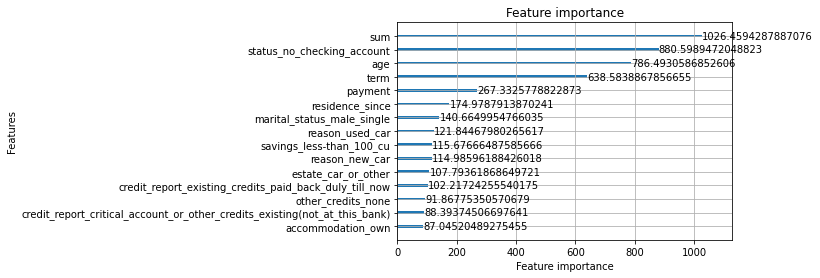

In [32]:
# important features
lgb.plot_importance(model, importance_type='gain', max_num_features=15)